# Intro to mmcv
#### *Author* : Pengxiao Gao (pengxiao.gao@momenta.ai)

In [13]:
import os
import os.path as osp
import mmcv

from mmcv import Config

## Config example

In [17]:
cfg = Config.fromfile('test/config/config_0.py')
print(cfg)

Config (path: test/config/config_0.py): {'a': 1, 'b': {'b1': [0, 1, 2], 'b2': None}, 'c': (1, 2), 'd': 'string'}


For all format configs, some ***predefined variables*** are supported. It will convert the variable in `{{ var }}` with its real value.

Currently, it supports four predefined variables:

`{{ fileDirname }}` - the current opened file’s dirname, e.g. /home/your-username/your-project/folder

`{{ fileBasename }}` - the current opened file’s basename, e.g. file.ext

`{{ fileBasenameNoExtension }}` - the current opened file’s basename with no file extension, e.g. file

`{{ fileExtname }}` - the current opened file’s extension, e.g. .ext

These variable names are referred from VS Code.

Here is one examples of config with predefined variables.

config_a.py

In [9]:
cfg = Config.fromfile('test/config/config_a.py')
print(cfg)

Config (path: test/config/config_a.py): {'a': 1, 'b': 'config_a', 'c': '.py'}


### Inherit from base config


In [4]:
cfg = Config.fromfile('test/config/config_b.py')
print(cfg)

Config (path: test/config/config_b.py): {'a': 1, 'b': '.py', 'c': 'config_b', 'd': 'str'}


### Inherit from multiple base configs (the base configs should not contain the same keys)

In [5]:
cfg = Config.fromfile('test/config/config_d.py')
print(cfg)

Config (path: test/config/config_d.py): {'a': 1, 'b': 'config_a', 'c': '.py', 'd': 'str', 'e': (1, 2)}


### Reference variables from base

In [6]:
cfg = Config.fromfile('test/config/config_e.py')
print(cfg)

Config (path: test/config/config_e.py): {'a': 1, 'b': 'config_a', 'c': '.py', 'd': 'str', 'e': (1, 2), 'item': {'a': 1, 'b': 'config_a'}}


## Registry

MMCV implements *registry* to manage different modules that share similar functionalities, e.g., backbones, head, and necks, in detectors. Most projects in OpenMMLab use registry to manage modules of datasets and models, such as MMDetection, MMDetection3D, MMClassification, MMEditing, etc.

To manage your modules in the codebase by *Registry*, there are three steps as below.

Create a build method (optional, in most cases you can just use the default one).

Create a `registry`.

Use this `registry` to manage the modules.

假设我们要实现一系列数据集转换器（Dataset Converter），用于将不同格式的数据转换为标准数据格式。我们先创建一个名为converters的目录作为包，在包中我们创建一个文件来实现构建器（builder），命名为converters/builder.py，如下



使用注册器管理模块的关键步骤是，将实现的模块注册到注册表 CONVERTERS 中。通过 @CONVERTERS.register_module() 装饰所实现的模块，字符串到类或函数之间的映射就可以由 CONVERTERS 构建和维护，如下所示：

通过这种方式，就可以通过 CONVERTERS 建立字符串与类或函数之间的映射，如下所示：

In [12]:
from converters.builder import CONVERTERS
from converters.converter1 import Converter_1
from converters.converter2 import converter_2
print(Converter_1)
print(converter_2)

<class 'converters.converter1.Converter_1'>
<function converter_2 at 0x7f0c697cb280>


In [12]:
# reshaping a tensor
t = torch.zeros(30)
t_reshape_1 = t.reshape(3, 10)
t_reshape_2 = t.view(3,10) # the same
print(t.shape, " --> ", t_reshape_1.shape)

torch.Size([30])  -->  torch.Size([3, 10])


In [13]:
# removing unnecessary dimensions (those dimensions of value 1 are not needed)
t = torch.zeros(1, 2, 1, 4, 1)
t_sqz = t.squeeze(2) # remove 3rd dim of 1
print(t.shape, " --> ", t_sqz.shape)

torch.Size([1, 2, 1, 4, 1])  -->  torch.Size([1, 2, 4, 1])


### Mathematical Operations on Tensors

In [14]:
t1 = 2*torch.rand(5,2) - 1
t2 = torch.normal(mean=0, std=1, size=(5,2))
print(t1)
print(t2)

tensor([[-0.1173, -0.4062],
        [ 0.6634, -0.7894],
        [-0.4610, -0.2824],
        [-0.6013,  0.0944],
        [-0.9877,  0.9031]])
tensor([[-1.1859, -0.8860],
        [-0.7150,  0.1280],
        [-0.1603, -2.2161],
        [-0.6858, -0.3295],
        [-0.2747, -1.2552]])


##### Element Wise Matrix Multiplication

In [15]:
t3 = t1.multiply(t2)
print(t3)

tensor([[ 0.1391,  0.3599],
        [-0.4743, -0.1011],
        [ 0.0739,  0.6258],
        [ 0.4123, -0.0311],
        [ 0.2714, -1.1336]])


##### Matrix-Matrix Product

In [16]:
t4 = torch.matmul(t1, t2.transpose(0, 1))
print(t1.shape, " x ", t2.transpose(0,1).shape, " = ", t4.shape)

torch.Size([5, 2])  x  torch.Size([2, 5])  =  torch.Size([5, 5])


##### Sum, Mean, Standard Deviation, and Norm

In [17]:
t_mean = t1.mean() # across all rows and columns
t_mean_row = t1.mean(axis=1)
t_mean_col = t1.mean(axis=0)
print(t_mean)
print(t_mean_row)
print(t_mean_col)

tensor(-0.1984)
tensor([-0.2617, -0.0630, -0.3717, -0.2534, -0.0423])
tensor([-0.3008, -0.0961])


In [18]:
t_sum = t1.sum()
t_std = t1.std()
print(f"sum = {t_sum}")
print(f"standard deviation = {t_std}")

sum = -1.984274983406067
standard deviation = 0.6057106256484985


In [19]:
t_norm = torch.linalg.norm(t1, ord=2, dim=1) # computer L2 norm of tensor for each roch
print(t_norm)

tensor([0.4227, 1.0311, 0.5406, 0.6086, 1.3383])


### Split, Stack and Concatenate Tensors

In [20]:
# divide a tensor into "n" equal chunks
t = torch.rand(6)
print(f"t = {t}")
t_splits = torch.chunk(t, chunks=3)
[f"Chunk {i} = {ch}" for i, ch in enumerate(t_splits)]

t = tensor([0.3068, 0.1165, 0.9103, 0.6440, 0.7071, 0.6581])


['Chunk 0 = tensor([0.3068, 0.1165])',
 'Chunk 1 = tensor([0.9103, 0.6440])',
 'Chunk 2 = tensor([0.7071, 0.6581])']

In [21]:
# stack or concatenate tensors
A = torch.ones(1, 3)
B = torch.zeros(4, 3)
C = torch.cat([A, B], axis=0)
print(f"A = {A}")
print(f"B = {B}")
print(f"C = {C}")

A = tensor([[1., 1., 1.]])
B = tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
C = tensor([[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


## Training Neural Networks with PyTorch

In the next section, we will build a simple neural network to classify handwritten digits from the MNIST data set.

In [25]:
import sklearn
import torchvision

%matplotlib inline 
import matplotlib.pyplot as plt

### Dataset Loading and Processing

In [22]:
from torch.utils.data import DataLoader
from sklearn.datasets import fetch_openml
from tqdm.notebook import tqdm

dataset = fetch_openml("mnist_784", version=1)

In [23]:
# see the contents in the dataset
print(list(dataset))
print(dataset.data.shape) # the images
print(dataset.target.shape) # the labels

['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url']
(70000, 784)
(70000,)


Let's visualize the classes in the MNIST dataset.

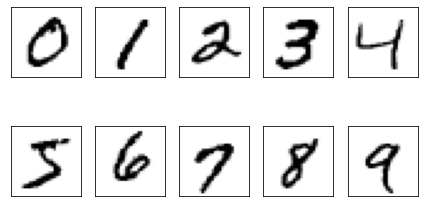

In [26]:
# Visualize some dataset instances
# plot some digits
X, y = dataset.data.values, dataset.target.astype(int).values

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten() # 1D iterator over array
for i in range(10):
    img = X[y==i][0].reshape(28,28)
    ax[i].imshow(img, cmap="Greys")
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

It is important to preprocess the data in some way before input into the neural network. They are sensitive to features with large magnitudes.

In [27]:
from sklearn.preprocessing import MinMaxScaler

min_max_scale = MinMaxScaler(feature_range=(-1, 1))
X_processed = min_max_scale.fit_transform(X)

Let's convert the `sklearn` dataset into one streamlined for `torch`.

When model training is running, we will train on train data and evaluate during training on validation data. We will additionally reserve a subset of the data as test data for model evaluation after training is complete.

In [28]:
from sklearn.model_selection import train_test_split
from torch.utils import data

def to_torch(x):
    if torch.is_tensor(x):
        return x
    return torch.from_numpy(x).to(torch.float32)

When training any Machine Learning algorithm, it is important to have representative instances of the general dataset population. A model will have poor performance if the training instance ratios it sees are not similar to the ratios of the real dataset. This type of equal sampling is called *stratified sampling.*

In [29]:
test_ratio = 0.15
val_ratio  = 0.2
# split into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X_processed, y, test_size=test_ratio, stratify=y)
# split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, stratify=y_temp)

# sklearn -> torch
X_train_t, y_train_t = to_torch(X_train), to_torch(y_train)
X_test_t, y_test_t  = to_torch(X_test), to_torch(y_test)
X_val_t, y_val_t = to_torch(X_val), to_torch(y_val)

train_dataset = data.TensorDataset(X_train_t, y_train_t)
test_dataset  = data.TensorDataset(X_test_t, y_test_t)
val_dataset   = data.TensorDataset(X_val_t, y_val_t)

In PyTorch, the `data.DataLoader` class handles feeding data to the model during training and evaluation.

In [30]:
b_size = 100

train_loader = data.DataLoader(train_dataset, batch_size=b_size, shuffle=True, drop_last=True, pin_memory=True)
val_loader  = data.DataLoader(val_dataset, batch_size=b_size, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_dataset, batch_size=b_size, shuffle=False, drop_last=False)

### Implementing a Neural Network in PyTorch

We will implement a simple Multilayer Perceptron to perform a logistic regression task.

<img src="mlp.png" alt="mlp" width="600"/>

The foundation of building neural networks from PyTorch is done through `torch.nn.Module`. These are the building blocks.

In [31]:
import torch.nn as nn

class LogisticRegression(nn.Module):
    def __init__(self, num_features=784, num_classes=10, hidden_sizes=[50]):
        """ 
        To add more layers in your network, add additional layer sizes to the "hidden_sizes" hyperparam
        """
        super().__init__()
        layers = []
        layer_sizes = [num_features] + hidden_sizes + [num_classes]
        for i in range(1, len(layer_sizes)):
            layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
        layers.append(nn.Sigmoid()) # added for logistic regression task
    
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

### Activation Functions
Since we are doing a Logistic Regression, the activation function of choice is a sigmoid. There are a myriad of activation functions for deep neural networks, each with its pros and cons. See a summary below or visit this [link](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions).

<img src="act_fns.png" width="450">

In [32]:
log_reg = LogisticRegression()
print(log_reg)

LogisticRegression(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
    (2): Sigmoid()
  )
)


Neural Network weight initialization is very important as successful training is dependent consistent gradient and variance flow across layers. For more details, see [here](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain).

In [33]:
def init_weights(model, factor=1):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            val = np.random.normal(loc=0.0, scale=0.1)
            param.data.fill_(val)
        else:
            nn.init.xavier_uniform_(param)

init_weights(log_reg)

We will now define the loss function and optimizers for our model. Since we are performing a logistic regression, a suitable loss function is Cross Entropy. For more details on loss functions, see [this link](https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23).

The optimization controls how fast our weights change (i.e. how big of a step is taken when performing gradient descent).

In [34]:
loss_module = nn.CrossEntropyLoss() # compute softmax then cross entropy
optim = torch.optim.SGD(log_reg.parameters(), lr=0.1)

In [36]:
def train(model, optimizer, train_loader, val_loader, loss_module, num_epochs=50, verbose=False):
    # set the model to train mode
    model.to(device)

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    pbar = tqdm(range(num_epochs))

    for epoch in pbar:
        train_loss, train_acc, val_acc = 0.0, 0, 0
        train_instances = 0
        val_instances = 0

        model.train()
        for features, labels in train_loader:
            # move tensors to GPU (or CPU if no GPU)
            features = features.to(device)
            labels = labels.to(device)

            predictions = model(features).squeeze(1)
            loss = loss_module(predictions, labels.long())
            
            # MUST ALWAYE DO THIS STEP
            optimizer.zero_grad() # clear out residual gradients (very important)

            loss.backward() # back propogation
            optimizer.step() # run gradient descent

            # metrics
            train_loss += loss.item()
            train_acc += (torch.argmax(predictions, dim=1) == labels).sum().item()

            train_instances += features.shape[0]

        train_losses.append(train_loss/train_instances)
        train_accuracies.append(train_acc/train_instances)

        # run validation loop
        model.eval()
        with torch.no_grad():
            for features, labels in val_loader:
                # same as train but only forward prop
                features = features.to(device)
                labels = labels.to(device)

                predictions = model(features).squeeze(1)
                val_acc += (torch.argmax(predictions, dim=1) == labels).sum().item()

                val_instances += features.shape[0]

        val_accuracies.append(val_acc/val_instances)

        if verbose:
            pbar.set_description(f"Epoch = {epoch}/{num_epochs} | "
                    f"Train MSE: {train_loss/train_instances:.4f} | " 
                    f"Train Acc: {train_acc/train_instances*100:.4f}% | " 
                    f"Val Acc: {val_acc/val_instances*100:.4f}%")

    return (train_losses, train_accuracies, val_accuracies)


In [37]:
num_epochs = 50
train_losses, train_accuracies, val_accuracies = train(log_reg, optim, train_loader, val_loader, 
                                                    loss_module, num_epochs=num_epochs, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

### Evaluation of the Neural Network

[]

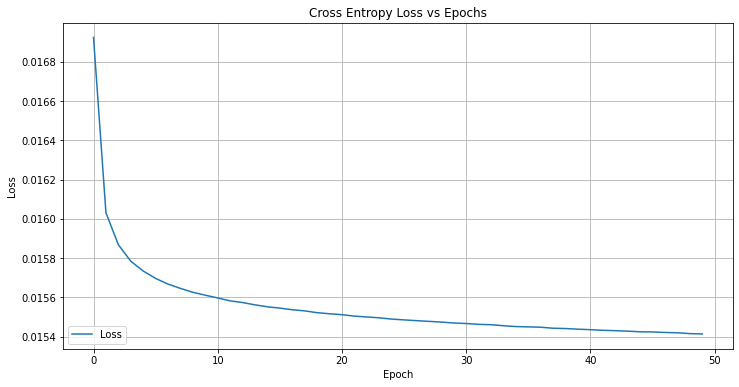

In [38]:
# plot the loss and accuracies

plt.figure(figsize=(12,6))
idx = [i for i in range(num_epochs)]
plt.plot(idx, train_losses, label="Loss")
plt.title("Cross Entropy Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend(loc="lower left")
plt.plot()

[]

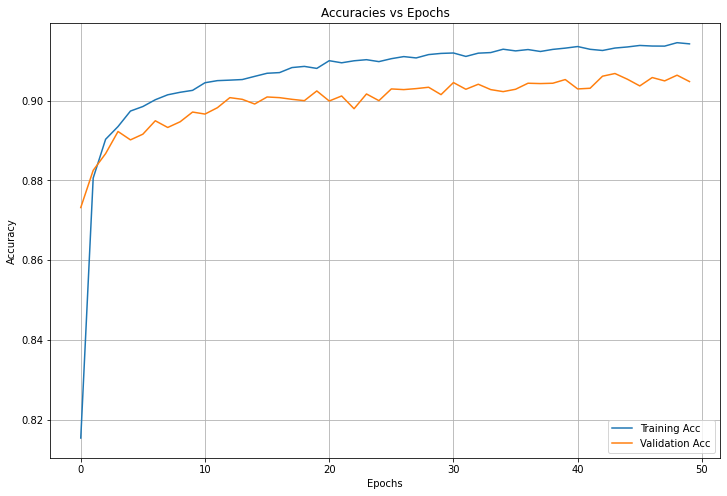

In [39]:
plt.figure(figsize=(12, 8))
plt.plot(idx, train_accuracies, label="Training Acc")
plt.plot(idx, val_accuracies, label="Validation Acc")
plt.title("Accuracies vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend(loc="lower right")
plt.plot()

You should see that after the "elbow" of the training graphs, the validation and training accuracies diverge from each other. This gap betweent the two curves is indicative of overfitting. Some things you can do are lower the learning rate, decrease the number of hidden layers, lower the number of epochs, etc.

Let's now evaluate the model on the test set.

In [40]:
@torch.no_grad()
def evaluate(model, test_loader):
    model.to(device)
    model.eval()
    num_examples = 0
    acc = 0.0
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        predictions = model(features)
        num_examples += features.shape[0]
        acc += (torch.argmax(predictions.cpu(), axis=1) == labels.cpu()).sum().item()
    acc /= num_examples
    print(f"Test Accuracy = {acc*100:.4f}%.")

In [41]:
evaluate(log_reg, test_loader)

Test Accuracy = 90.9810%.


The test accuracy is similar to the train and validation accuracies. Play around with the model to try and improve your score!

Some things you can try are:
1. Data preprocessing - transform the training inputs more to lower the bias of the model.
2. Hyperparameter tuning - change the number of layers, the hidden dimension size, the learning rate, etc.

### Saving and Reloading Model

Saving the full model

In [42]:
model_path = "simple_log_reg.pt"
torch.save(log_reg, model_path)

In [43]:
# reload the model
log_reg_reload = torch.load(model_path)
# verify that the model is the same
print(log_reg_reload.eval())
# now verfiy the weights are the same by evaluating it on test set
evaluate(log_reg_reload, test_loader)

LogisticRegression(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
    (2): Sigmoid()
  )
)
Test Accuracy = 90.9810%.


Saving only the learned parameters

In [44]:
path = "simple_log_reg_state.pt"
torch.save(log_reg.state_dict(), path)

# reload saved parameters to reconstruct model
log_reg_reload = LogisticRegression()
log_reg_reload.load_state_dict(torch.load(path)) 

# now verfiy the weights are the same by evaluating it on test set
evaluate(log_reg_reload, test_loader)

Test Accuracy = 90.9810%.
